In [1]:
# Step 0: Download repository and unzipp folder in google drive. 

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from pickle import load
# Import helper functions from pre_processing.py:
import sys
sys.path.append('/content/gdrive/My Drive/Recurrent_GRF_Prediction-main/')
from pre_processing import *

In [3]:
# import data
df = pd.read_csv('/content/gdrive/My Drive/Recurrent_GRF_Prediction-main/data/Sample_test_data.csv')

# Notes about test data:
# NO FOOTSTRIKE DATA
# X is vertical acceleration (including gravitation)
# Z is anteroposterior (sign is flipped though)
# Velocity is around 3 m/s
# Height is 175 cm
# Mass is 60 kg
# Sampling Frequency is 512 Hz

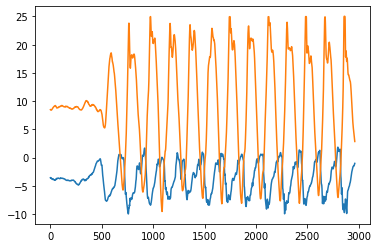

In [4]:
# reorient to match training data coordinate system
Sacrum_V = df['Accel_LN_X']*-1
Sacrum_AP = df['Accel_LN_Z']*-1

plt.plot(Sacrum_AP)
plt.plot(Sacrum_V)

In [5]:
# pre processing for acceleration signal
# filter
Sacrum_V_f = buttfilt(Sacrum_V, 512, 20, 4, axis=0)
Sacrum_AP_f = buttfilt(Sacrum_AP, 512, 20, 4, axis=0)

# set negative sacrum vertical acceleration to 0
Sacrum_V_f[Sacrum_V_f < 0] = 0

# load scaler for subject info and signals
sub_scaler = load(open('/content/gdrive/My Drive/Recurrent_GRF_Prediction-main/LSTM_scaler.pkl', 'rb'))
V_accel_max = load(open('/content/gdrive/My Drive/Recurrent_GRF_Prediction-main/V_accel_max.pkl', 'rb'))
AP_accel_max = load(open('/content/gdrive/My Drive/Recurrent_GRF_Prediction-main/AP_accel_max.pkl', 'rb'))


# Split trial into 2 parts. Window_data_centered() expects 2D array
X_V = np.vstack((Sacrum_V_f[1000:1500], Sacrum_V_f[1500:2000])) #  each trial is a row
X_AP = np.vstack((Sacrum_AP_f[1000:1500], Sacrum_AP_f[1500:2000])) #  each trial is a row

# Insert your subject and condition info here (2 trials in this example):
sub_info = {'Height': [175, 175], 'Mass': [60,60], 'Speed': [3.0, 3.0], 'Slope': [0, 0]}
sub_info = pd.DataFrame(data=sub_info)
sub_info_scaled = sub_scaler.transform(sub_info)

# break signal into 6-frame windows for LSTM
window_size = 6
X_V = window_data_centered(X_V, window_size, verbose = False)
X_AP = window_data_centered(X_AP, window_size, verbose = False)

# Generate features
feats_V = signal_features(X_V, 512)
feats_AP = signal_features(X_AP, 512)

# scale input features based on model training data
def max_scale_3d(feats, train_max):
  feats_scaled = feats / train_max
  print('max used to normalize: ',train_max)
  return feats_scaled

feats_V_scaled = max_scale_3d(feats_V, V_accel_max)
feats_AP_scaled = max_scale_3d(feats_AP, AP_accel_max) 

# join AP & V accel signal features together
signal_feats = np.concatenate((feats_V_scaled, feats_AP_scaled), axis = 2)
print('Shape of signal features: ', signal_feats.shape)

# create 3d array of scaled subject/condition info features (height, mass, speed, slope) that matches shape of signal features
sub_cond_feats = np.ones((2, 500, 4))*sub_info_scaled[0,:]
print('Shape of subject/condition features: ', sub_cond_feats.shape)

#concatenate subject and signal features 
input_features = np.concatenate((signal_feats, sub_cond_feats), axis = 2)
print('Input feature shape: ', input_features.shape)

max used to normalize:  [22.61166667 11.90211559 27.11      ]
max used to normalize:  [ 5.42166667 12.39942931 31.06      ]
Shape of signal features:  (2, 500, 6)
Shape of subject/condition features:  (2, 500, 4)
Input feature shape:  (2, 500, 10)


In [6]:
# NO FOOTSTRIKE DATA AVAILABLE, so use all_subs_model_wo_footstrike.h5
#Download model file from https://zenodo.org/record/5213939 and save in /data/ folder.
saved_model = keras.models.load_model('/content/gdrive/My Drive/Recurrent_GRF_Prediction-main/data/all_subs_model_wo_footstrike.h5')

In [7]:
# Make prediction 
GRF = saved_model.predict(input_features)

Text(0.5, 0, 'Time [seconds]')

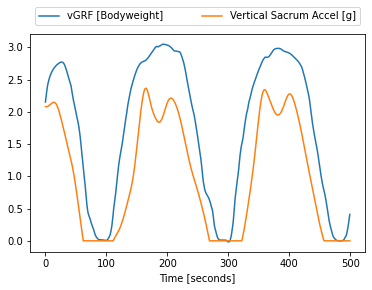

In [8]:
# Plot prediction for 1st trial
plt.plot(np.squeeze(GRF[0,:]), label='vGRF [Bodyweight]')
plt.plot(Sacrum_V_f[1000:1500]/9.81, label='Vertical Sacrum Accel [g]')
plt.legend(bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', mode='expand', ncol=2)
plt.xlabel('Time [seconds]')
